## Nympyro model library  
A library contaning numpyro models for future reference.  The model naming convention corresponds to models replicated in R using `brms` and `rethinking` and also in Python using `PyMC`.  

### Imports

In [1]:
# from jax import grad, jit, vmap
# import jax
from jax import random
import jax.numpy as jnp
import datetime as dt

# import pyro
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import arviz as az

/home/brent/anaconda3/envs/pytorch_pyro/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data  

`stock_data.csv` contains the same data as is stored in the similarly named Rdata file in my R package [romerb](https://github.com/Brent-Morrison/romerb)

In [2]:
# Read data
df_raw = pd.read_csv('stock_data.csv')

# New df for analysis
df1 = df_raw
df1['date_stamp']= pd.to_datetime(df1['date_stamp'], format="%d/%m/%Y")
df1 = df1[df1['date_stamp'] == '2021-06-30'].copy()

# Scale function
scale = lambda x: (x - x.mean()) / x.std()

df1['log_mkt_cap'] = np.log(df1['mkt_cap'])
df1['log_assets'] = np.log(df1['total_assets'])
df1['log_equity_cln'] = np.log(-df1['total_equity_cln'])
df1['roe'] = -df1['roe']
df1['roe_s'] = df1.roe.pipe(scale)
df1['leverage_s'] = df1.leverage.pipe(scale)

le = LabelEncoder()
df1['sector_tf'] = le.fit_transform(df1['sector'].values)

cols = ['date_stamp', 'symbol', 'log_mkt_cap', 'log_assets', 'log_equity_cln', 'roe', 'roe_s', 'leverage', 'leverage_s', 'sector_tf', 'log_pb']
df1 = df1[cols].copy()

df1.head()

,date_stamp,symbol,log_mkt_cap,log_assets,log_equity_cln,roe,roe_s,leverage,leverage_s,sector_tf,log_pb
53,2021-06-30,A,10.716239,9.177197,8.477204,0.166845,0.383000,0.503411,-0.688139,6,2.234926
86,2021-06-30,AA,8.833674,9.606428,8.520388,-0.031416,-0.353283,0.662450,0.167220,10,0.313342
146,2021-06-30,AAL,9.515441,11.035019,8.732434,-1.000000,-3.950308,1.110744,2.578291,0,0.783072
203,2021-06-30,AAN,7.672204,7.906806,7.327254,-0.165563,-0.851463,0.439851,-1.029989,0,0.345311
239,2021-06-30,AAP,9.518787,9.379208,8.177379,0.135932,0.268199,0.699356,0.365717,3,1.343235


### Model 1

Multi level regression WITH correlation b/w intercept and slope 

| Model        | Attribute description         | Attribute description         |
| --------------------- |:------------------------------|:------------------------------|
| symbol | the ticker symbol identifying the company | the ticker symbol identifying the company |
| date_stamp | date_stamp | date_stamp |



In [3]:
def m1(grp1, x1, y = None):
    a = numpyro.sample("a", dist.Normal(1.25, 1))                                        # prior for population level intercept
    b = numpyro.sample("b", dist.Normal(1, 1.5))                                         # prior for population level slope
    #sigma_grp1 = numpyro.sample("sigma_grp1", dist.Exponential(1).expand([2]))          # prior for standard deviation of group level effects ('sd' per brms)
    sigma_grp1 = numpyro.sample('sigma_grp1', dist.Exponential(1), sample_shape=(2,))    # prior for standard deviation of group level effects ('sd' per brms)
    Rho = numpyro.sample("Rho", dist.LKJ(2, 2))                                          # prior for correlation b/w group level slopes & intercepts
    
    cov = jnp.matmul(jnp.matmul(jnp.diag(sigma_grp1), Rho), jnp.diag(sigma_grp1))        # construct variance / covariance mtrx b/w slopes & intercepts
    #cov = jnp.outer(sigma_grp1, sigma_grp1) * Rho                                       # construct variance / covariance mtrx b/w slopes & intercepts (alternate)
    
    a_grp1_b_grp1 = numpyro.sample("a_grp1_b_grp1", dist.MultivariateNormal(
        loc=jnp.stack([a, b]), covariance_matrix=cov) \
        .expand(batch_shape=[11]))                    # prior for mv norm dist b/w slopes & intercepts
    a_grp1 = a_grp1_b_grp1[:, 0]
    b_grp1 = a_grp1_b_grp1[:, 1]
    
    mu = a_grp1[grp1] + b_grp1[grp1] * x1                                                # linear model
    sigma = numpyro.sample("sigma", dist.Exponential(1))                                 # prior for residual SD of response distribution

    numpyro.sample("y", dist.Normal(mu, sigma), obs=y)                                   # likelihood


Run MCMC

In [4]:
m1_mcmc = MCMC(NUTS(m1), num_warmup=1000, num_samples=1000, num_chains=1)
m1_mcmc.run(random.PRNGKey(0),  grp1=df1.sector_tf.values, x1=df1.roe.values, y=df1.log_pb.values)

  0%|          | 0/2000 [00:00<?, ?it/s]/home/brent/anaconda3/envs/pytorch_pyro/lib/python3.9/site-packages/jax/_src/tree_util.py:185: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
sample: 100%|██████████| 2000/2000 [00:19<00:00, 100.96it/s, 15 steps of size 4.04e-01. acc. prob=0.88]


Render model

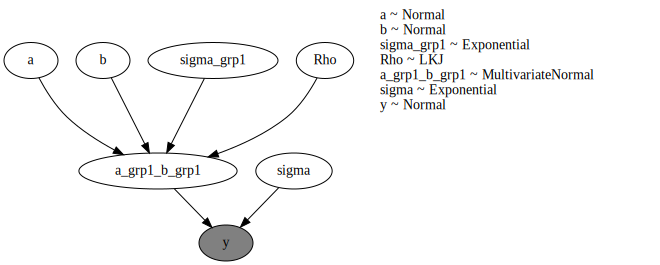

In [5]:
grp1 = jnp.arange(1, 12, 1, dtype=int)
x1 = jnp.ones(11)
y = jnp.ones(11)
numpyro.render_model(m1, model_args=(grp1, x1, y), render_distributions=True)

Summary coefficients

In [6]:
m1_mcmc.print_summary()


                         mean       std    median      5.0%     95.0%     n_eff     r_hat
           Rho[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
           Rho[0,1]     -0.45      0.24     -0.47     -0.82     -0.08    819.76      1.00
           Rho[1,0]     -0.45      0.24     -0.47     -0.82     -0.08    819.76      1.00
           Rho[1,1]      1.00      0.00      1.00      1.00      1.00    941.51      1.00
                  a      0.90      0.19      0.90      0.60      1.20    733.85      1.00
 a_grp1_b_grp1[0,0]      1.35      0.07      1.35      1.24      1.47   1464.27      1.00
 a_grp1_b_grp1[0,1]      0.81      0.22      0.80      0.44      1.17   1233.19      1.00
 a_grp1_b_grp1[1,0]      1.50      0.10      1.50      1.34      1.68    838.82      1.01
 a_grp1_b_grp1[1,1]      1.56      0.32      1.55      1.08      2.10    909.22      1.00
 a_grp1_b_grp1[2,0]      0.98      0.15      0.99      0.76      1.23    726.27      1.00
 a_grp1_b

In [7]:
# Sample from posterior
m1_post = m1_mcmc.get_samples()

In [8]:
# To arviz
m1_arviz = az.from_numpyro(posterior=m1_mcmc)

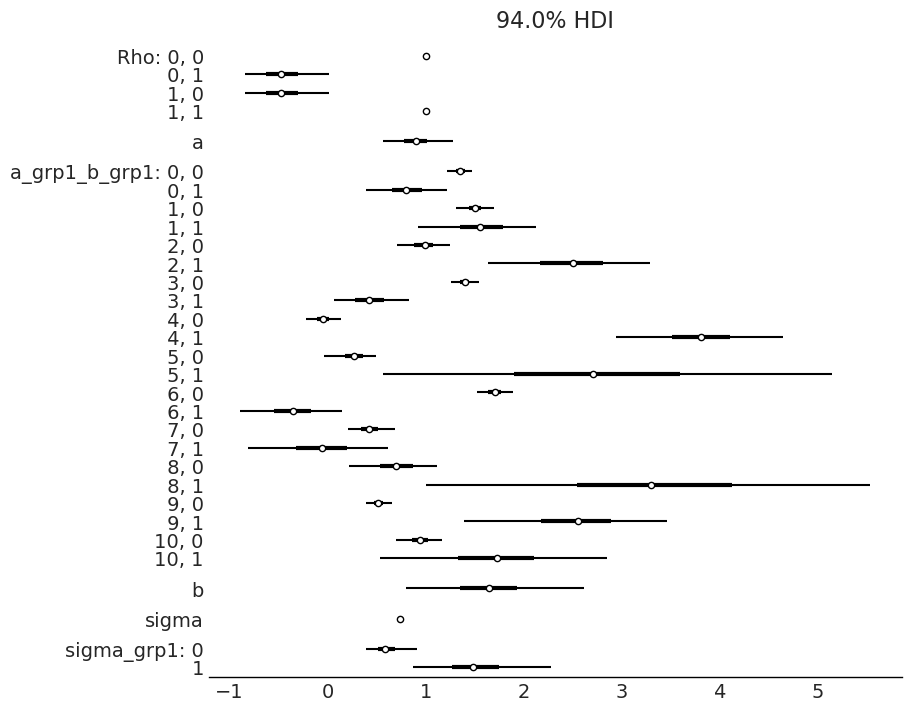

In [9]:
az.style.use("arviz-grayscale")

#centered_data = az.load_arviz_data(m1_arviz)
#non_centered_data = az.load_arviz_data("non_centered_eight")
az.plot_forest(
    data=m1_arviz,
    kind="forestplot",
    combined=True,
    #ridgeplot_overlap=3,
    #colors='white',
    figsize=(9, 7)
)
plt.show()

In [10]:
m1_arviz

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Random notes looking at sample shape

The examples below demonstrate the difference between *sample shape* (that specified with the `sample_shape` parameter of the `sample` method) and *batch shape* (that specified with the `batch_shape` parameter of the `expand` method).

Note that batch shape signifies the dimension of XXXXX.

[Reference](https://ericmjl.github.io/blog/2019/5/29/reasoning-about-shapes-and-probability-distributions/)

In [27]:
d = dist.Exponential(1) \
    .sample(random.PRNGKey(42), sample_shape=(3,))

print(d)
print("\n")
print(d.shape)
print("\n")
print(dist.Exponential(1).event_shape)

[0.85365486 0.10553633 0.06130229]


(3,)


()


In [25]:
d = dist.Exponential(1) \
    .expand(batch_shape=(1,)) \
    .sample(random.PRNGKey(42), sample_shape=(3,))

print(d)
print("\n")
print(d.shape)
print("\n")
print(d.event_shape)

[[0.85365486]
 [0.10553633]
 [0.06130229]]


(3, 1)




AttributeError: 'DeviceArray' object has no attribute 'event_shape'

In [13]:
d = dist.Exponential(1) \
    .expand(batch_shape=(2,)) \
    .sample(random.PRNGKey(42), sample_shape=(3,))

print(d)
print("\n")
print(d.shape)

[[1.3086625  2.0340383 ]
 [2.0580726  0.23342834]
 [0.206562   0.7990092 ]]
(3, 2)


In [14]:
d = dist.Exponential(1) \
    .expand(batch_shape=[2]) \
    .sample(random.PRNGKey(42), sample_shape=(2,))

print(d)
print("\n")
print(d.shape)

[[0.85365486 1.9423788 ]
 [0.06130229 0.06438442]]
(2, 2)


In [15]:
d = dist.LKJ(2, 2).sample(random.PRNGKey(42), sample_shape=(1,))

print(d)
print("\n")
print(d.shape)

[[[1.         0.44555074]
  [0.44555074 1.        ]]]
(1, 2, 2)


In [26]:
d = dist.LKJ(2, 2) \
    .expand(batch_shape=[2]) \
    .sample(random.PRNGKey(42), sample_shape=(1,))

print(d)
print("\n")
print(d.shape)
print("\n")
print(d.event_shape)

[[[[ 1.          0.44442013]
   [ 0.44442013  1.        ]]

  [[ 1.         -0.11944741]
   [-0.11944741  1.        ]]]]


(1, 2, 2, 2)




AttributeError: 'DeviceArray' object has no attribute 'event_shape'

In [17]:
d = dist.LKJ(2, 2) \
    .expand(batch_shape=[2]) \
    .sample(random.PRNGKey(42), sample_shape=(2,))

print(d)
print("\n")
print(d.shape)

[[[[ 1.         -0.11571874]
   [-0.11571874  1.        ]]

  [[ 1.          0.79887456]
   [ 0.79887456  1.        ]]]


 [[[ 1.         -0.3299536 ]
   [-0.3299536   1.        ]]

  [[ 1.          0.3581291 ]
   [ 0.3581291   1.        ]]]]
(2, 2, 2, 2)


In [23]:
lkj = dist.LKJ(2, 2)
lkj_sample = lkj.sample(random.PRNGKey(42), sample_shape=(1,))

print(lkj.event_shape)
print("\n")
print(lkj_sample)

(2, 2)


[[[1.         0.44555074]
  [0.44555074 1.        ]]]


In [19]:
lkj_sample = lkj.sample(random.PRNGKey(42), sample_shape=(1,))

d = dist.MultivariateNormal(
        loc=jnp.stack([1, 2]),
        covariance_matrix=jnp.matmul(jnp.matmul(jnp.diag(jnp.array([3, 4])), lkj_sample), jnp.diag(jnp.array([3, 4])))
        ) \
        .sample(random.PRNGKey(42), sample_shape=(1,))

print(d)
print("\n")
print(d.shape)
print("\n")
print(lkj_sample)

[[[-5.509478  -0.2026074]]]


(1, 1, 2)


[[[1.         0.44555074]
  [0.44555074 1.        ]]]


In [20]:
lkj_sample = lkj.sample(random.PRNGKey(42), sample_shape=(1,))

d = dist.MultivariateNormal(
        loc=jnp.stack([1, 2]),
        covariance_matrix=jnp.matmul(jnp.matmul(jnp.diag(jnp.array([3, 4])), lkj_sample), jnp.diag(jnp.array([3, 4])))
        ) \
        .expand(batch_shape=(6,)) \
        .sample(random.PRNGKey(42), sample_shape=(1,))

print(d)
print("\n")
print(d.shape)

[[[ 2.1126237  -1.5476623 ]
  [-0.5430193   8.057651  ]
  [-2.8950949  -2.4994526 ]
  [ 2.6727245   3.3619635 ]
  [-1.4942696  -0.81697655]
  [-0.64660287 -1.1234295 ]]]


(1, 6, 2)


In [21]:
lkj_sample = lkj.sample(random.PRNGKey(42), sample_shape=(1,))

d = dist.MultivariateNormal(
        loc=jnp.stack([1, 2]),
        covariance_matrix=jnp.matmul(jnp.matmul(jnp.diag(jnp.array([3, 4])), lkj_sample), jnp.diag(jnp.array([3, 4])))
        ) \
        .expand(batch_shape=(1,)) \
        .sample(random.PRNGKey(42), sample_shape=(6,))

print(d)
print("\n")
print(d.shape)

[[[ 2.1126237  -1.5476623 ]]

 [[-0.5430193   8.057651  ]]

 [[-2.8950949  -2.4994526 ]]

 [[ 2.6727245   3.3619635 ]]

 [[-1.4942696  -0.81697655]]

 [[-0.64660287 -1.1234295 ]]]


(6, 1, 2)


In [22]:
cov_mat = jnp.matmul(jnp.matmul(jnp.diag(jnp.array([3, 4])), lkj_sample), jnp.diag(jnp.array([3, 4])))

print(cov_mat)
print("\n")
print(cov_mat.shape)

[[[ 9.        5.346609]
  [ 5.346609 16.      ]]]


(1, 2, 2)
